In [3]:
from PIL import Image
import numpy as np
import os

In [136]:
def resize(input_dir, output_dir, target_size=(48,48)):
    os.makedirs(output_dir, exist_ok=True)

    for kuva in os.listdir(input_dir):
        img_path = os.path.join(input_dir, kuva)
        img = Image.open(img_path)
        resized = img.resize(target_size, Image.BICUBIC)
        resized = resized.convert('RGB')
        resized.save(os.path.join(output_dir, kuva))

resize("./data/angryv2", "./data/resized_angryv2")
resize("./data/happyv2", "./data/resized_happyv2")
resize("./data/sadv2", "./data/resized_sadv2")

In [137]:
import torch
from torchvision import transforms
import torch.nn.functional as F

angry_path = "./data/resized_angryv2"
happy_path = "./data/resized_happyv2"
sad_path = "./data/resized_sadv2"

valid_extensions = ('.jpg', '.jpeg', '.png')

data = []
labels = []

to_tensor = transforms.ToTensor()

for kuva in os.listdir(angry_path):
    if kuva.endswith(valid_extensions):
        img_path = os.path.join(angry_path, kuva)
        img = Image.open(img_path)
        tensori = to_tensor(img)
        data.append(tensori)
        labels.append(0)

for kuva in os.listdir(happy_path):
    if kuva.endswith(valid_extensions):
        img_path = os.path.join(happy_path, kuva)
        img = Image.open(img_path)
        tensori = to_tensor(img)
        data.append(tensori)
        labels.append(1)

for kuva in os.listdir(sad_path):
    if kuva.endswith(valid_extensions):
        img_path = os.path.join(sad_path, kuva)
        img = Image.open(img_path)
        tensori = to_tensor(img)
        data.append(tensori)
        labels.append(2)

data = torch.stack(data)
labels = torch.tensor(labels)
labels = F.one_hot(labels)

In [138]:
print(data.shape)
print(labels.shape)

torch.Size([678, 3, 48, 48])
torch.Size([678, 3])


In [139]:
from torch.utils.data import DataLoader, TensorDataset, random_split


labeled_data = TensorDataset(data, labels)

train_dataset, test_dataset = random_split(labeled_data, [0.8, 0.2])

loaders = {
    "train": DataLoader(train_dataset, 
                        batch_size=16),
    "test": DataLoader(test_dataset,
                       batch_size=len(test_dataset))
}

In [140]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1b6d3f81290>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1b6d3e86d50>}

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

n = len(data)
m = int(0.8*n)
logistic_regression = LogisticRegression(max_iter=200)
random_indices = torch.randint(0, n, (n,))
train_data_logistic_regression = data.view(n, -1)[random_indices]
labels_logistic_regression = labels.argmax(dim=1)[random_indices]
logistic_regression.fit(train_data_logistic_regression[:m], labels_logistic_regression[:m])
predictions = logistic_regression.predict(train_data_logistic_regression[m:])
print(((predictions == labels_logistic_regression[m:]).sum() / len(predictions) * 100).item())

svm = SVC(max_iter=200)
svm.fit(train_data_logistic_regression[:m], labels_logistic_regression[:m])
predictions = svm.predict(train_data_logistic_regression[m:])
print(((predictions == labels_logistic_regression[m:]).sum() / len(predictions) * 100).item())

C:\Users\aatus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


86.76470184326172


C:\Users\aatus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


78.67646789550781


In [19]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [167]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(6400, 100)
        self.fc2 = nn.Linear(100, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # x = self.dropout(x)
        # x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

C:\Users\aatus\AppData\Local\Temp\ipykernel_11608\3693992404.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 - loss: 1.0890
Train Epoch: 2 - loss: 1.0977
Train Epoch: 3 - loss: 1.0933
Train Epoch: 4 - loss: 1.0492
Train Epoch: 5 - loss: 0.9617
Train Epoch: 6 - loss: 1.0285
Train Epoch: 7 - loss: 0.9107
Train Epoch: 8 - loss: 0.8070
Train Epoch: 9 - loss: 0.9959
Train Epoch: 10 - loss: 0.8396
Train Epoch: 11 - loss: 0.8639
Train Epoch: 12 - loss: 0.9864
Train Epoch: 13 - loss: 1.0037
Train Epoch: 14 - loss: 0.8242
Train Epoch: 15 - loss: 0.7985
Train Epoch: 16 - loss: 0.7617
Train Epoch: 17 - loss: 0.7455
Train Epoch: 18 - loss: 0.7564
Train Epoch: 19 - loss: 0.8236
Train Epoch: 20 - loss: 0.8484
Train Epoch: 21 - loss: 0.6860
Train Epoch: 22 - loss: 0.8062
Train Epoch: 23 - loss: 0.8521
Train Epoch: 24 - loss: 0.7342
Train Epoch: 25 - loss: 0.8162
Train Epoch: 26 - loss: 0.8398
Train Epoch: 27 - loss: 0.8068
Train Epoch: 28 - loss: 0.8559
Train Epoch: 29 - loss: 0.7343
Train Epoch: 30 - loss: 0.7479
Train Epoch: 31 - loss: 0.8238
Train Epoch: 32 - loss: 0.7792
Train Epoch: 33 -

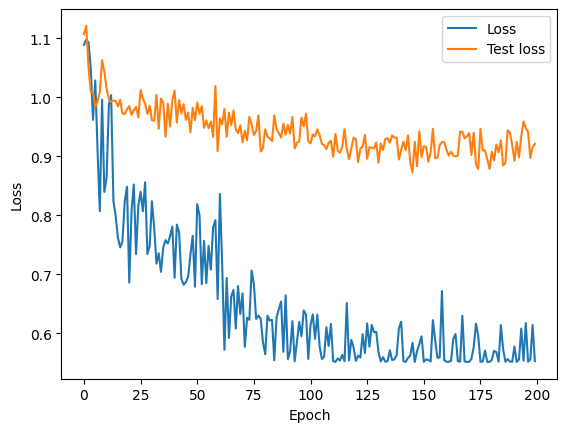

In [175]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 200


# training
losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
test_data, test_target = next(iter(loaders['test']))
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        target = target.to(data.dtype)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    losses[epoch] = loss.item()
    test_losses[epoch] = loss_fn(model(test_data), test_target.to(test_data.dtype)).item()
    print(f'Train Epoch: {epoch + 1} - loss: {loss.item():.4f}')

# testing
with torch.no_grad():
    data, target = next(iter(loaders['test']))
    data, target = data.to(device), target.to(device)
    target = target.to(data.dtype)
    output = model(data)
    test_loss = loss_fn(output, target).item()
    pred = output.argmax(dim=1, keepdim = True)
    target = target.argmax(dim=1, keepdim = True)
    correct = pred.eq(target.view_as(pred)).sum().item()

    print(f'\nTest loss: {test_loss:.4f}, Test accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)')

plt.plot(losses, label="Loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


C:\Users\aatus\AppData\Local\Temp\ipykernel_11608\3857961901.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


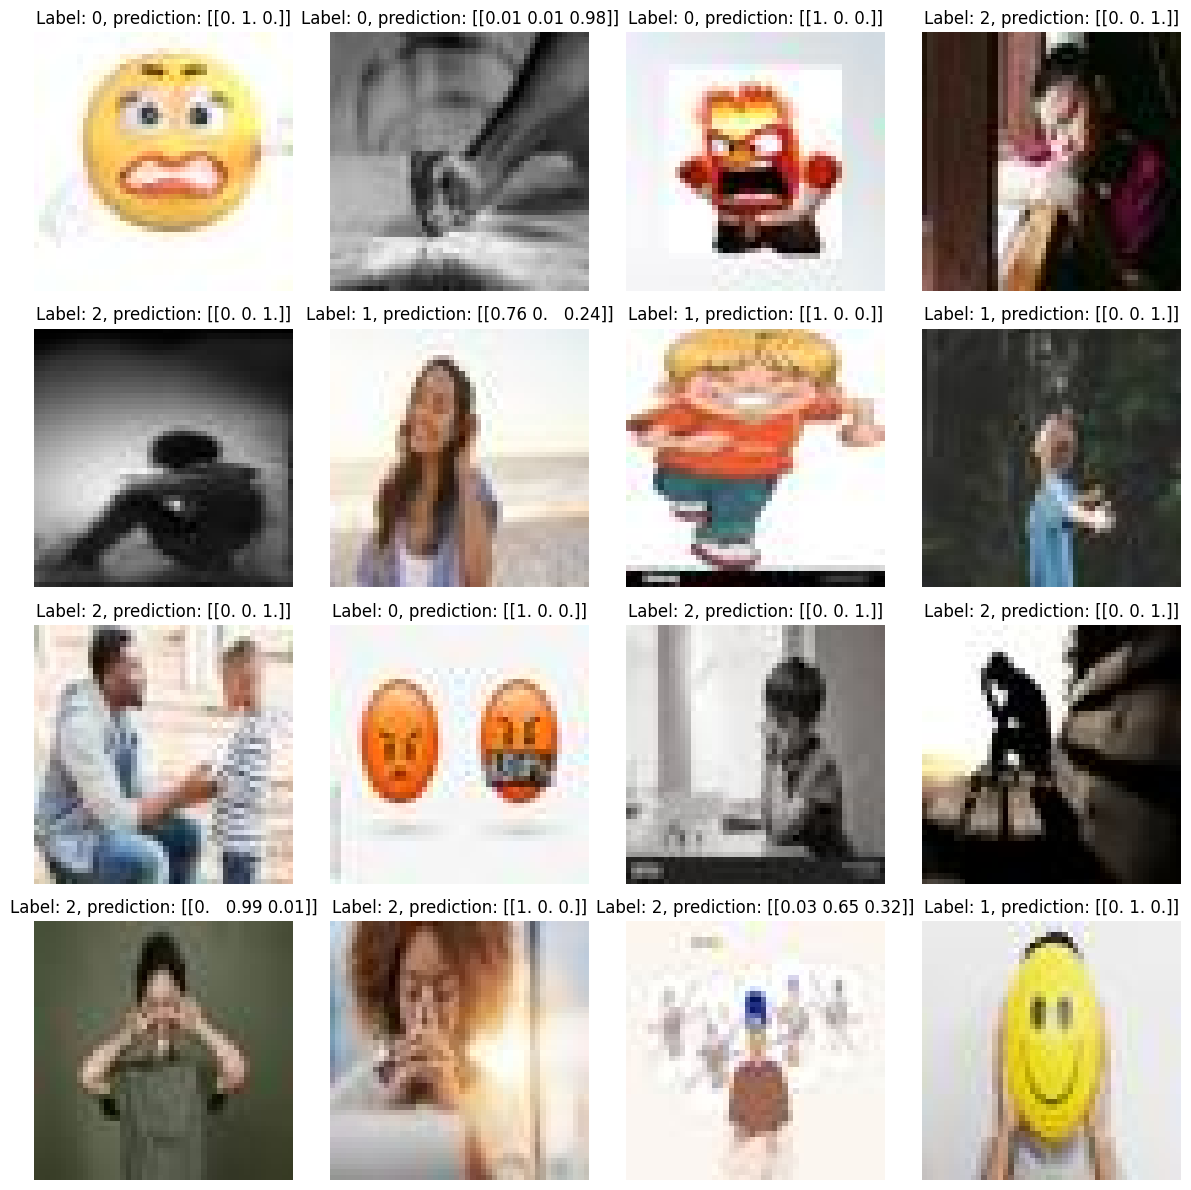

In [157]:
data, target = next(iter(loaders['test']))
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for img, ax, label in zip(data[:16], axes, target[:16]):
    prediction = model(img.unsqueeze(0)).detach().numpy().round(2)
    img = img.numpy().transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Label: {label.argmax().item()}, prediction: {prediction}')
    ax.axis('off')
plt.tight_layout()
plt.show()

C:\Users\aatus\AppData\Local\Temp\ipykernel_11608\3857961901.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


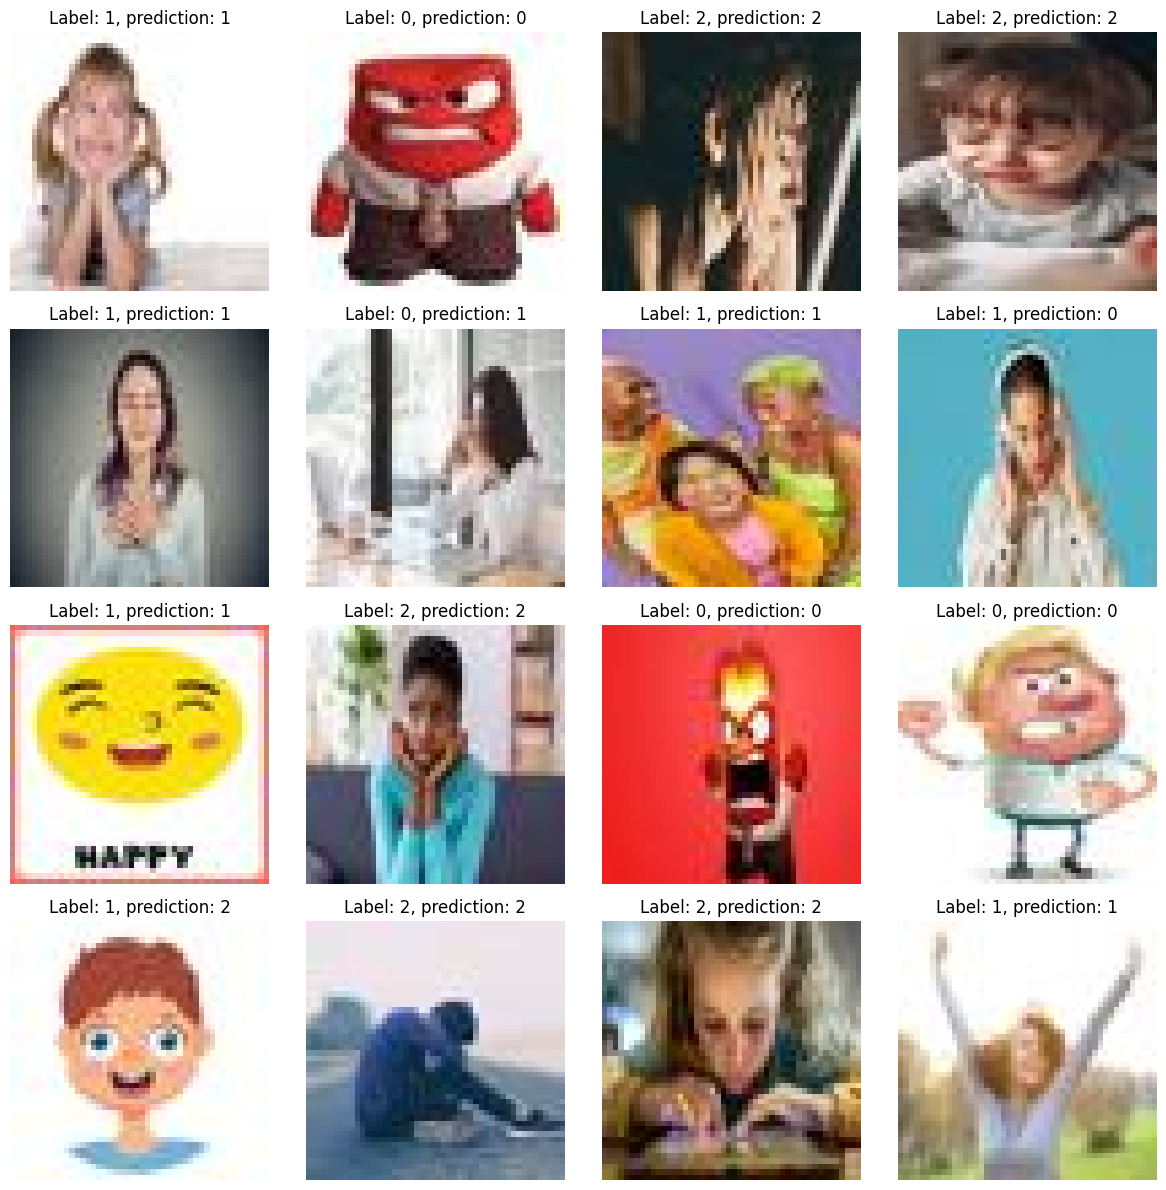

In [156]:
data, target = next(iter(loaders['train']))
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for img, ax, label in zip(data[:16], axes, target[:16]):
    prediction = model(img.unsqueeze(0)).argmax().item()
    img = img.numpy().transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Label: {label.argmax().item()}, prediction: {prediction}')
    ax.axis('off')
plt.tight_layout()
plt.show()